In [1]:
#!/usr/bin/env python
import lz4.frame as lz4f
import cloudpickle
import json
import pprint
import numpy as np
import awkward
np.seterr(divide='ignore', invalid='ignore', over='ignore')
from coffea.arrays import Initialize
from coffea import hist, processor
from coffea.util import load, save
from coffea.jetmet_tools import FactorizedJetCorrector, JetCorrectionUncertainty, JetTransformer, JetResolution, JetResolutionScaleFactor
from optparse import OptionParser
from uproot_methods import TVector2Array, TLorentzVectorArray


### Baseline Event selection 2018

general:

1. $E^T_{miss}$≥ 100 GeV
2. no loose $\gamma$
3. 1(0) tight(loose) e($\mu$) or 1(0) tight(loose) ($\mu$)(e)
4. ele triggers for e events
5. $\mu$ triggers for ($\mu$) events
6. $\delta$φ(leading AK4 jet, MET)> 1.5
7. $\delta$R(leading AK4 jet, $e$ / $\mu$ )< 3.4

### next steps

1. add condition for Data and MC in the processor
2. add condition for skipping W+jets Ht < 100 Gev
3. consider new samples


In [14]:
class AnalysisProcessor(processor.ProcessorABC):
    lumis = { #Values from https://twiki.cern.ch/twiki/bin/viewauth/CMS/PdmVAnalysisSummaryTable                                                      
        '2016': 35.92,
        '2017': 41.53,
        '2018': 59.74
    }
    
    def __init__(self, year, xsec):
        self._year = year
        self._lumi = 1000.*float(AnalysisProcessor.lumis[year])
        self._xsec = xsec

        self._accumulator = processor.dict_accumulator({

            'sumw': hist.Hist(
                'sumw', 
                hist.Cat('dataset', 'Dataset'), 
                hist.Bin('sumw', 'Weight value', [0.])
            ),

            'mT': hist.Hist(
                'Events',
                hist.Cat('dataset', 'Dataset'),
                hist.Cat('region', 'Region'),
                hist.Bin('mT', '$m_{T}$ [GeV]', 20, 0, 600)),
            'eT_miss': hist.Hist(
                'Events',
                hist.Cat('dataset', 'Dataset'),
                hist.Cat('region', 'Region'),
                hist.Bin('eT', '$E^T_{miss}$[GeV]', 20, 0, 600)),


            'ele_pT': hist.Hist(
                'Events',
                hist.Cat('dataset', 'dataset'),
                hist.Cat('region', 'Region'),
                hist.Bin('pT', 'Tight electron $p_{T}$ [GeV]', 10, 0, 200)),

            'mu_pT': hist.Hist(
                'Events',
                hist.Cat('dataset', 'dataset'),
                hist.Cat('region', 'Region'),
                hist.Bin('pT', 'Tight Muon $p_{T}$ [GeV]', 10, 0, 200)),

            'jet_pT': hist.Hist(
                'Events',
                hist.Cat('dataset', 'dataset'),
                hist.Cat('region', 'Region'),
                hist.Bin('pT', 'Leading $AK4 Jet p_{T}$ [GeV]',
                         [30.0, 60.0, 90.0, 120.0, 150.0, 180.0, 210.0, 250.0, 280.0, 310.0, 340.0, 370.0, 400.0, 430.0, 470.0, 510.0, 550.0, 590.0, 640.0, 690.0, 740.0, 790.0, 840.0, 900.0, 960.0, 1020.0, 1090.0, 1160.0, 1250.0])),
            'dphi_e_etmiss': hist.Hist(
                'Events',
                hist.Cat('dataset', 'dataset'),
                hist.Cat('region', 'Region'),
                hist.Bin('dphi', '$\Delta\phi (e, E^T_{miss} )$', 30, 0, 3.5)),
            'dphi_mu_etmiss': hist.Hist(
                'Events',
                hist.Cat('dataset', 'dataset'),
                hist.Cat('region', 'Region'),
                hist.Bin('dphi', '$\Delta\phi (\mu, E^T_{miss} )$', 30, 0, 3.5)),
          
            'cutflow': processor.defaultdict_accumulator(int)
        }
        )

        self._samples = {
            'secr':['WJets','DY','TT','ST','WW','WZ','ZZ','QCD','SingleElectron'],
            'smcr':['WJets','DY','TT','ST','WW','WZ','ZZ','QCD','SingleMuon'],
            'tecr':['WJets','DY','TT','ST','WW','WZ','ZZ','QCD','SingleElectron'],
            'tmucr':['WJets','DY','TT','ST','WW','WZ','ZZ','QCD','SingleMuon'],
            'wecr':['WJets','DY','TT','ST','WW','WZ','ZZ','QCD', 'SingleElectron'],
            'wmucr':['WJets','DY','TT','ST','WW','WZ','ZZ','QCD','SingleMuon'],
            # 'dilepe':'DY','TT','ST','WW','WZ','ZZ','SingleElectron'),
            # 'dilepm':'DY','TT','ST','WW','WZ','ZZ','SingleMuon')

        }
                                            
    @property
    def accumulator(self):
        return self._accumulator

    def process(self, events):

        # This gets us the accumulator dictionary we defined in init
        output = self.accumulator.identity()
        dataset_name = events.metadata['dataset'].split('_')[0]
        dataset = events.metadata['dataset']

        isFilled=False


#                 print("a JetHT dataset was found and the processor has excluded events with W_pT <100 GeV because we are trying to inspect the W+Jets Low pT sample")
        Electron = events.Electron
        Muon = events.Muon
        Met = events.MET
        Jet = events.Jet
        
#         output['cutflow']['all events'] += events.size
#         else: pass
      # **********step 1 Object Selection***************
        '''
        1. Electrons: 
          a. Tight Electron
          b. Loose Electron
          c. Ele['T'] = ( pt*cos(phi), pt*sin(phi))
          d. Ele['p4']
        '''
        Electron['T'] = TVector2Array.from_polar(Electron.pt, Electron.phi)
        Electron['p4'] = TLorentzVectorArray.from_ptetaphim(
          Electron.pt, Electron.eta, Electron.phi, Electron.mass)

        TightEleSel = ~(Electron.pt == np.nan)
        TightEleSel = (((Electron.pt > 40) &
                      (abs(Electron.eta) < 1.4442) &
                      (abs(Electron.dxy) < 0.05) &
                      (abs(Electron.dz) < 0.1) &
                      (Electron.cutBased == 4)) |
                     ((Electron.pt > 40) &
                      (abs(Electron.eta) > 1.5660) &
                      (abs(Electron.eta) < 2.5) &
                      (abs(Electron.dxy) < 0.1) &
                      (abs(Electron.dz) < 0.2) &
                      (Electron.cutBased == 4)
                      ))  # Trigger: HLT_Ele32_WPTight_Gsf_v

        LooseEleSel = ~(Electron.pt == np.nan)
        LooseEleSel = (((Electron.pt > 10) &
                      (abs(Electron.eta) < 1.4442) &
                      (abs(Electron.dxy) < 0.05) &
                      (abs(Electron.dz) < 0.1) &
                      (Electron.cutBased >= 1)) |
                     ((Electron.pt > 10) &
                      (abs(Electron.eta) > 1.5660) &
                      (abs(Electron.eta) < 2.5) &
                      (abs(Electron.dxy) < 0.1) &
                      (abs(Electron.dz) < 0.2) &
                      (Electron.cutBased >= 1)))

        TightElectron = Electron[TightEleSel]
        LooseElectron = Electron[LooseEleSel]
        LeadingEle = TightElectron[TightElectron.pt.argmax()]
        #         output['ele_pt'].fill(dataset=dataset,
        #                      region='everthing',
        #                      pT = Electron.pt[LooseEleSel].flatten())

        '''
        2. Muons:
          a. Tight Muon
          b. Loose Muon
          c. Mu['T'] = ( pt*cos(phi), pt*sin(phi))
          d. Mu['p4']
        '''
        Muon['T'] = TVector2Array.from_polar(Muon.pt, Muon.phi)
        Muon['p4'] = TLorentzVectorArray.from_ptetaphim(
          Muon.pt, Muon.eta, Muon.phi, Muon.mass)

        TightMuSel = ~(Muon.pt == np.nan)
        TightMuSel = (
          (Muon.pt > 30) &
          (abs(Muon.eta) < 2.4) &
          (Muon.tightId) &
          (Muon.pfRelIso04_all < 0.15)
        )

        LooseMuonSel = ~(Muon.pt == np.nan)
        LooseMuonSel = (Muon.pt > 15) & (abs(Muon.eta) < 2.4) & (
          Muon.looseId > 0) & (Muon.pfRelIso04_all < 0.25)

        LooseMuon = Muon[LooseMuonSel]
        TightMuon = Muon[TightMuSel]
        LeadingMu = TightMuon[TightMuon.pt.argmax()]
        '''
        3. Photons:
          a. Loose photon
          b. Tight Photon

        '''
        Photon = events.Photon
        # just a complicated way to initialize a jagged array with the needed shape to True
        LoosePhoSel = ~(Photon.pt == np.nan)
        LoosePhoSel = (
          (Photon.pt > 15) &
          ~((abs(Photon.eta) > 1.4442) & (abs(Photon.eta) < 1.566)) &
          (abs(Photon.eta) < 2.5) &
          (abs(Photon.cutBasedBitmap & 1) == 1)
        )

        TightPhoSel = ~(Photon.pt == np.nan)
        TightPhoSel = ((Photon.pt > 230) & ((Photon.cutBasedBitmap & 2) == 2))

        LoosePhoton = Photon[LoosePhoSel]
        TightPhoton = Photon[TightPhoSel]

        #         output['ele_pt'].fill(dataset=dataset,
        #              region='everthing',
        #              pT = TightPhoton.pt.flatten())

        '''
        4. MET:
        Met['T']  = TVector2Array.from_polar(Met.pt, Met.phi)
        Met['p4'] = TLorentzVectorArray.from_ptetaphim(Met.pt, 0., Met.phi, 0.)
        TightMet =  ~(Met.pt==np.nan)
        '''

        Met['T'] = TVector2Array.from_polar(Met.pt, Met.phi)
        Met['p4'] = TLorentzVectorArray.from_ptetaphim(Met.pt, 0., Met.phi, 0.)
        TightMet = ~(Met.pt == np.nan)

        '''
        5. Jets:
        '''

        Jet['T'] = TVector2Array.from_polar(Jet.pt, Jet.phi)
        Jet['p4'] = TLorentzVectorArray.from_ptetaphim(
          Jet.pt, Jet.eta, Jet.phi, Jet.mass)
        LeadingJet = Jet[Jet.pt.argmax()]

        # ******** step 2: triggers*******

        # single e triggers for e events
        EleTrigger = ['Ele32_WPTight_Gsf',
                    'Ele115_CaloIdVT_GsfTrkIdT', 'Photon200']

        # single mu triggers for µ events
        MuTrigger = ['IsoMu24',
                   'Mu50',
                   'OldMu100',
                   'TkMu100']
        # Photon trigger
        PhoTrigger = ['Photon200']

        # met trigger
        MetTrigger = ['PFMETNoMu120_PFMHTNoMu120_IDTight_PFHT60',
                    'PFMETNoMu120_PFMHTNoMu120_IDTight']

        # ************ calculate delta phi( leading ak4jet, met) > 1.5***********

        Jet['T'] = TVector2Array.from_polar(Jet.pt, Jet.phi)
        Jet['p4'] = TLorentzVectorArray.from_ptetaphim(
          Jet.pt, Jet.eta, Jet.phi, Jet.mass)
        LeadingJet = Jet[Jet.pt.argmax()]

        Delta_Phi_Met_LJ = (Met['T'].delta_phi(LeadingJet['T'].sum()) > 1.5)

        # *******calculate deltaR( leading ak4jet, e/mu) < 3.4 *****
        LJ_Ele = LeadingJet['p4'].cross(TightElectron['p4'])
        DeltaR_LJ_Ele = LJ_Ele.i0.delta_r(LJ_Ele.i1)
        DeltaR_LJ_Ele_mask = (DeltaR_LJ_Ele < 3.4).any()

        LJ_Mu = LeadingJet['p4'].cross(TightMuon['p4'])
        DeltaR_LJ_Mu = LJ_Mu.i0.delta_r(LJ_Mu.i1)
        DeltaR_LJ_Mu_mask = (DeltaR_LJ_Mu < 3.4).any()

        # *****btag
        # https://twiki.cern.ch/twiki/bin/viewauth/CMS/BtagRecommendation102X#Supported_Algorithms_and_Operati
        # medium     0.4184
        btagWP_medium = 0.4184
        Jet_btag_medium = Jet[Jet['btagDeepB'] > btagWP_medium]

        # ****** to add event selection in coffea ********

        selection = processor.PackedSelection()

        triggers = np.zeros(events.size, dtype=np.bool)
        for path in MetTrigger:
            if path not in events.HLT.columns:
                continue
            triggers = triggers | events.HLT[path]
        selection.add('met_triggers', triggers)
        selection.add('TightMet', (Met.pt >= 100))

        triggers = np.zeros(events.size, dtype=np.bool)
        for path in EleTrigger:
            if path not in events.HLT.columns:
                continue
            triggers = triggers | events.HLT[path]
        selection.add('ele_triggers', triggers)

        triggers = np.zeros(events.size, dtype=np.bool)
        for path in MuTrigger:
            if path not in events.HLT.columns:
                continue
            triggers = triggers | events.HLT[path]
        selection.add('mu_triggers', triggers)
        selection.add('one_electron', (TightElectron.counts == 1))
        selection.add('zero_loose_muon', (LooseMuon.counts == 0))
        selection.add('zero_loose_photon', (LoosePhoton.counts == 0))
        selection.add('zero_medium_btags',
                    (Jet[Jet['btagDeepB'] > btagWP_medium].counts == 0))
        selection.add('Delta_Phi_Met_LJ', (Delta_Phi_Met_LJ))
        selection.add('DeltaR_LJ_Ele', (DeltaR_LJ_Ele_mask))

        selection.add('one_muon', (TightMuon.counts == 1))
        selection.add('zero_loose_electron', (LooseElectron.counts == 0))
        selection.add('DeltaR_LJ_Mu', (DeltaR_LJ_Mu_mask))

        selection.add('atleast_2_medium_btag',
                    (Jet[Jet['btagDeepB'] > btagWP_medium].counts >= 2))

        selection.add('exactly_1_medium_btag',
                    (Jet[Jet['btagDeepB'] > btagWP_medium].counts == 1))

        '''
        what the next 6 lines of code do:

        main object is to exclude events from JetHt sample with W_pT b/w 70-100 GeV

        events.metadata['dataset'] = 'WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8____27_'
        dataset = 'WJetsToLNu'

        see if the 'HT' is in the name of the sample
        so, it first goes to genpart,
        figures out if the genlevel process is hardprocess and firstcopy and there are genlevel particle with 
        abs(pdgID)= 24

        ad selects only those events for the pT of W was > 100 GeV

        '''

        # predeclration just in cas I don't want the filter
        selection.add("exclude_low_WpT_JetHT", np.full(len(events), True))
        if dataset_name == 'WJetsToLNu':
            if events.metadata['dataset'].split('-')[0].split('_')[1] == 'HT':
                GenPart = events.GenPart
                remove_overlap = (GenPart[GenPart.hasFlags(['fromHardProcess', 'isFirstCopy', 'isPrompt']) &
                                        ((abs(GenPart.pdgId) == 24))].pt > 50).all()
                selection.add("exclude_low_WpT_JetHT", remove_overlap)

        else:
            selection.add("exclude_low_WpT_JetHT", np.full(len(events), True))
        # i dont think I need a photon trigger
        #         triggers = np.zeros(events.size, dtype=np.bool)
        #         for path in PhoTrigger:
        #             if path not in events.HLT.columns: continue
        #             triggers = triggers | events.HLT[path]
        #         selection.add('pho_triggers', triggers)

        selection.add('DeltaR_LJ_mask',
                    (DeltaR_LJ_Ele_mask | DeltaR_LJ_Mu_mask))

        #
        region = {
          'wecr': (selection.all(*( 
                                   'ele_triggers',
                                   'TightMet',
                                   'one_electron',
                                   'zero_loose_muon',
                                   'zero_loose_photon',
                                   'zero_medium_btags',
                                   'Delta_Phi_Met_LJ',
                                   'DeltaR_LJ_Ele',
                                   'exclude_low_WpT_JetHT'
                                   )),
                   np.sqrt(2*LeadingEle.pt.sum()*Met.pt *
                           (1-np.cos(Met.T.delta_phi(LeadingEle.T.sum()))))
                   ),
          'wmucr': (selection.all(*(
                                    'mu_triggers',
                                    'TightMet',
                                    'one_muon',
                                    'zero_loose_electron',
                                    'zero_loose_photon',
                                    'zero_medium_btags',
                                    'Delta_Phi_Met_LJ',
                                    'DeltaR_LJ_Mu',
                                    'exclude_low_WpT_JetHT'
                                    )),
                    np.sqrt(2*LeadingMu.pt.sum()*Met.pt *
                            (1-np.cos(Met.T.delta_phi(LeadingMu.T.sum()))))
                    ),
          'tecr': (selection.all(*(
                                   'ele_triggers',
                                   'TightMet',
                                   'one_electron',
                                   'zero_loose_muon',
                                   'zero_loose_photon',
                                   'atleast_2_medium_btag',
                                   'Delta_Phi_Met_LJ',
                                   'DeltaR_LJ_Ele',
                                   'exclude_low_WpT_JetHT'
                                   )),
                   np.sqrt(2*LeadingEle.pt.sum()*Met.pt *
                           (1-np.cos(Met.T.delta_phi(LeadingEle.T.sum()))))
                   ),
          'tmucr': (selection.all(*(
                                    'mu_triggers',
                                    'TightMet',
                                    'one_muon',
                                    'zero_loose_electron',
                                    'zero_loose_photon',
                                    'atleast_2_medium_btag',
                                    'Delta_Phi_Met_LJ',
                                    'DeltaR_LJ_Mu',
                                    'exclude_low_WpT_JetHT'
                                    )),
                    np.sqrt(2*LeadingMu.pt.sum()*Met.pt *
                            (1-np.cos(Met.T.delta_phi(LeadingMu.T.sum()))))
                    ),
          'secr': (selection.all(*(
                                   'ele_triggers',
                                   'TightMet',
                                   'one_electron',
                                   'zero_loose_muon',
                                   'zero_loose_photon',
                                   'exactly_1_medium_btag',
                                   'Delta_Phi_Met_LJ',
                                   'DeltaR_LJ_Ele',
                                   'exclude_low_WpT_JetHT'
                                   )),
                   np.sqrt(2*LeadingEle.pt.sum()*Met.pt *
                           (1-np.cos(Met.T.delta_phi(LeadingEle.T.sum()))))
                   ),
          'smucr': (selection.all(*(
                                    'mu_triggers',
                                    'TightMet',
                                    'one_muon',
                                    'zero_loose_electron',
                                    'zero_loose_photon',
                                    'exactly_1_medium_btag',
                                    'Delta_Phi_Met_LJ',
                                    'DeltaR_LJ_Mu',
                                    'exclude_low_WpT_JetHT'
                                    )),
                    np.sqrt(2*LeadingMu.pt.sum()*Met.pt *
                            (1-np.cos(Met.T.delta_phi(LeadingMu.T.sum()))))
                    )


        }

        for reg, sel_mt in region.items():
            output['mT'].fill(dataset=dataset,
                            region=reg,
                            mT=sel_mt[1][sel_mt[0]].flatten())
            output['eT_miss'].fill(dataset=dataset,
                                 region=reg,
                                 eT=Met[sel_mt[0]].pt.flatten())
            output['ele_pT'].fill(dataset=dataset,
                                region=reg,
                                pT=TightElectron[sel_mt[0]].pt.flatten())
            output['mu_pT'].fill(dataset=dataset,
                               region=reg,
                               pT=TightMuon[sel_mt[0]].pt.flatten()),
        #data condition
        if 'genWeight' in events.columns:
          if not isFilled:
            output['sumw'].fill(dataset=dataset, sumw=1, weight=events.genWeight.sum())
            isFilled=True
#               print(reg,'->events.genWeight.sum()->',events.genWeight.sum())
#               print(reg,'->events.size->',events.size,'\n')

#               print("lumi:", self._lumi,
#                    "sxec:", self._xsec[dataset],
#                    "lumi*xs", )
        else:
          if not isFilled:
            output['sumw'].fill(dataset=dataset, sumw=1, weight=1)
            isFilled=True
        return output


    def postprocess(self, accumulator):
        scale = {}
        for d in accumulator['sumw'].identifiers('dataset'):
            print('Scaling:',d.name)
            dataset = d.name
            if '--' in dataset: dataset = dataset.split('--')[1]
            print('Cross section:',self._xsec[dataset])
            if self._xsec[dataset]!= -1: scale[d.name] = self._lumi*self._xsec[dataset]
            else: scale[d.name] = 1
        print('scale_postprocess-->', scale, self._lumi )
        
        for histname, h in accumulator.items():
            if histname == 'sumw': continue
            if isinstance(h, hist.Hist):
                h.scale(scale, axis='dataset')

        return accumulator


In [15]:
fileset = {'WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8____1_':
[
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_128.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_129.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_13.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_130.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_131.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_132.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_133.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_134.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_135.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_136.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_137.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_138.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_139.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_14.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_140.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_141.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_142.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_143.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_144.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_145.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_146.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_147.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_148.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_149.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_15.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_150.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_151.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_152.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_153.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_154.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_155.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_156.root"
        ],
          'DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8____0_':
          [
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_1.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_10.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_100.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_101.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_102.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_103.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_104.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_105.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_106.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_107.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_108.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_109.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_11.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_110.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_111.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_112.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_113.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_114.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_115.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_116.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_117.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_118.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_119.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_12.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_120.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_121.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_122.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_123.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_124.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_125.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_126.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_127.root"
        ],
#          'MET____0_'  :
#            [
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_1.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_10.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_100.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_101.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_102.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_103.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_104.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_105.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_106.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_107.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_108.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_109.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_11.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_110.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_111.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_112.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_113.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_114.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_115.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_116.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_117.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_118.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_119.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_12.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_120.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_121.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_122.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_123.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_124.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_125.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_126.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_127.root"
#         ]
}
#Run Coffea code using uproot
with open('2018_test.json') as fin:
    samplefiles = json.load(fin)
    xsec = {k: v['xs'] for k, v in samplefiles.items()}
    
# corrections = load('../data/corrections.coffea')
output = processor.run_uproot_job(fileset,
                                  treename='Events',
                                  processor_instance=AnalysisProcessor('2018', xsec),
                                  executor=processor.futures_executor,
                                  executor_args={'workers': 4, 'flatten': True, 'nano':True},
                                 )


Scaling: DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8____0_
Cross section: 160.8
Scaling: WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8____1_
Cross section: 1392
scale_postprocess--> {'DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8____0_': 9606192.0, 'WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8____1_': 83158080.0} 59740.0


In [19]:
9606192.0/11516745.770996094

0.8341064560261758

In [20]:
83158080.0/29481346.024414062


2.8207016033506482

In [24]:
with open('/uscms_data/d3/runiyal/decaf_aug21/decaf/analysis/metadata/2018.json') as fin:
    samplefiles = json.load(fin)
    xsec = {k: v['xs'] for k, v in samplefiles.items()}

In [28]:
xsec_ = {}
for k, v in xsec.items():
  xsec_[k.split('____')[0]] = v

In [30]:
xsec_,

{'MET': -1,
 'EGamma': -1,
 'ZJetsToNuNu_HT-100To200_13TeV-madgraph': 303.4,
 'ZJetsToNuNu_HT-200To400_13TeV-madgraph': 91.71,
 'ZJetsToNuNu_HT-400To600_13TeV-madgraph': 13.1,
 'ZJetsToNuNu_HT-600To800_13TeV-madgraph': 3.248,
 'ZJetsToNuNu_HT-800To1200_13TeV-madgraph': 1.496,
 'ZJetsToNuNu_HT-1200To2500_13TeV-madgraph': 0.3425,
 'ZJetsToNuNu_HT-2500ToInf_13TeV-madgraph': 0.005268,
 'DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8': 160.8,
 'DYJetsToLL_M-50_HT-200to400_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8': 48.63,
 'DYJetsToLL_M-50_HT-400to600_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8': 6.975,
 'DYJetsToLL_M-50_HT-600to800_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8': 1.756,
 'DYJetsToLL_M-50_HT-800to1200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8': 0.8094,
 'DYJetsToLL_M-50_HT-1200to2500_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8': 0.1931,
 'DYJetsToLL_M-50_HT-2500toInf_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8': 0.003513,
 'WJetsToLNu_HT-100To200_T

In [36]:
genWeught_dict ={'QCD_HT300to500_TuneCP5_13TeV-madgraphMLM-pythia8':54594132.90625,
'WJetsToLNu_Wpt-0To50_TuneCP5_13TeV-amcatnloFXFX-pythia8':18750973352848.0,
'DYJetsToLL_M-50_HT-200to400_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8':11204572.82006836,
'ZJetsToNuNu_HT-200To400_13TeV-madgraph':23232889.450195312,
'MET' :5125.0,
'WZ_TuneCP5_13TeV-pythia8' :3884166.94140625,
'ZJetsToNuNu_HT-2500ToInf_13TeV-madgraph':350168.8583984375,
'ST_tW_antitop_5f_inclusiveDecays_TuneCP5_13TeV-powheg-pythia8':266470389.875,
'ZJetsToNuNu_HT-400To600_13TeV-madgraph':9483322.952392578,
'WJetsToLNu_HT-400To600_TuneCP5_13TeV-madgraphMLM-pythia8':5913597.715759277,
'WJetsToLNu_HT-1200To2500_TuneCP5_13TeV-madgraphMLM-pythia8' :7567071.056640625,
'QCD_HT700to1000_TuneCP5_13TeV-madgraphMLM-pythia8' :48028220.96166992,
'DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8' :11516745.770996094,
'ZJetsToNuNu_HT-100To200_13TeV-madgraph' :23675935.83203125,
'EGamma':19886.0,
'QCD_HT1500to2000_TuneCP5_13TeV-madgraphMLM-pythia8' :10883854.442749023,
'ST_t-channel_antitop_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8' :5125997103.125,
'ZJetsToNuNu_HT-1200To2500_13TeV-madgraph':340171.0078125,
'WJetsToLNu_HT-200To400_TuneCP5_13TeV-madgraphMLM-pythia8':25415128.875,
'WJetsToLNu_HT-800To1200_TuneCP5_13TeV-madgraphMLM-pythia8' :8357921.15234375,
'GJets_1j_Gpt-650ToInf_5f_NLO_Autumn18' :355388.83363342285,
'TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8' :298029859662.0,
'WW_TuneCP5_13TeV-pythia8' :7846135.853515625,
'DYJetsToLL_M-50_HT-400to600_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8' :9614508.719726562,
'ST_tW_top_5f_inclusiveDecays_TuneCP5_13TeV-powheg-pythia8' :334874746.1015625,
'ZJetsToNuNu_HT-600To800_13TeV-madgraph' :5726462.8896484375,
'GJets_1j_Gpt-400To650_5f_NLO_Autumn18' :54664818.81347656,
'DYJetsToLL_M-50_HT-800to1200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8' :3120982.0595703125,
'QCD_HT200to300_TuneCP5_13TeV-madgraphMLM-pythia8' :54247036.296875,
'GJets_1j_Gpt-250To400_5f_NLO_Autumn18 sumgenweights':217662176.57714844,
'WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8' :29481346.024414062,
'QCD_HT1000to1500_TuneCP5_13TeV-madgraphMLM-pythia8' :15403521.732910156,
'ST_t-channel_top_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8' :16578753642.5,
'DYJetsToLL_M-50_HT-600to800_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8' :8826238.055664062,
'QCD_HT2000toInf_TuneCP5_13TeV-madgraphMLM-pythia8' :5412264.48046875,
'DYJetsToLL_M-50_HT-1200to2500_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8' :531566.8515625,
'GJets_1j_Gpt-100To250_5f_NLO_Autumn18' :16388549497.780273,
'DYJetsToLL_M-50_HT-2500toInf_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8' :415517.01708984375,
'WJetsToLNu_HT-2500ToInf_TuneCP5_13TeV-madgraphMLM-pythia8' :3189396.021484375,
'QCD_HT500to700_TuneCP5_13TeV-madgraphMLM-pythia8' :55046820.94433594,
'ZZ_TuneCP5_13TeV-pythia8' :1978776.7138671875,
'ZJetsToNuNu_HT-800To1200_13TeV-madgraph' :2055725.501953125,
'WJetsToLNu_HT-600To800_TuneCP5_13TeV-madgraphMLM-pythia8' :19690762.064941406}

In [40]:
SF = {}
for k,v in xsec_.items():
  if k not in genWeught_dict.keys():continue
  elif k in ['MET', 'EGamma']:continue
  SF[k]=(xsec_[k]*59740)/genWeught_dict[k]

In [41]:
SF

{'ZJetsToNuNu_HT-100To200_13TeV-madgraph': 0.7655501403867835,
 'ZJetsToNuNu_HT-200To400_13TeV-madgraph': 0.2358189415804215,
 'ZJetsToNuNu_HT-400To600_13TeV-madgraph': 0.08252318347995909,
 'ZJetsToNuNu_HT-600To800_13TeV-madgraph': 0.033884008984106484,
 'ZJetsToNuNu_HT-800To1200_13TeV-madgraph': 0.043474208942336626,
 'ZJetsToNuNu_HT-1200To2500_13TeV-madgraph': 0.06014901190896886,
 'ZJetsToNuNu_HT-2500ToInf_13TeV-madgraph': 0.0008987387440430491,
 'DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8': 0.8341064560261758,
 'DYJetsToLL_M-50_HT-200to400_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8': 0.2592830843846732,
 'DYJetsToLL_M-50_HT-400to600_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8': 0.04333934391728864,
 'DYJetsToLL_M-50_HT-600to800_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8': 0.011885407955055133,
 'DYJetsToLL_M-50_HT-800to1200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8': 0.015493057978890522,
 'DYJetsToLL_M-50_HT-1200to2500_TuneCP5_PSweights_13TeV-madg

<Figure size 720x720 with 0 Axes>

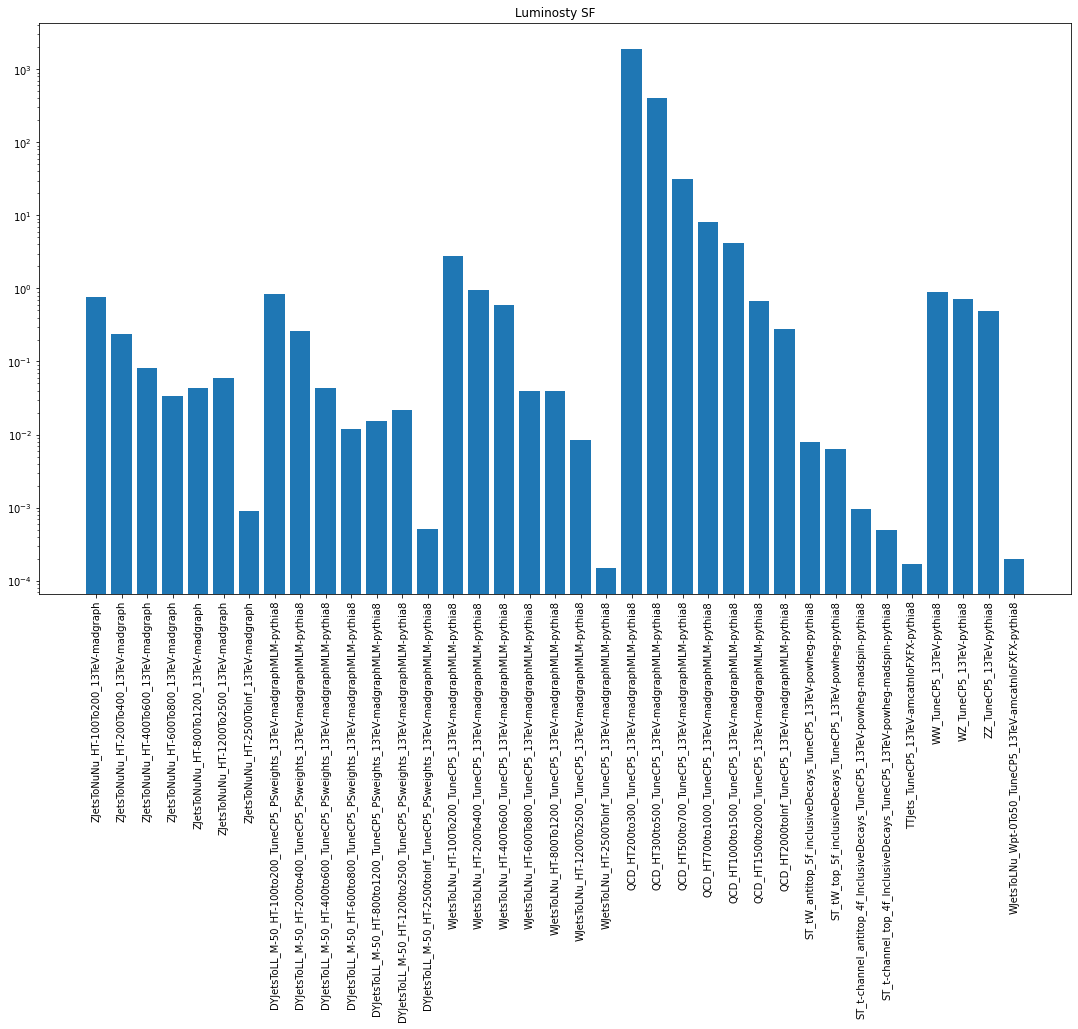

In [60]:
import matplotlib.pyplot as plt
fig = plt.gcf()
fig.set_size_inches(10, 10)

_, ax = plt.subplots()
plt.bar(range(len(SF)), list((SF.values())), align='center')
plt.xticks(range(len(SF)), list(SF.keys()), rotation='vertical')
plt.title('Luminosty SF')
ax.set_yscale('log')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

In [35]:
hist.plot1d(h.integrate('region'), overlay='dataset',stack=True)

AttributeError: 'NoneType' object has no attribute 'integrate'

In [38]:
output['mu_pT'].scale(3)

In [36]:
h

In [26]:
9606192.0/3240252.57421875


2.9646429653145563

In [27]:
83158080.0/4482855.2578125

18.550248718174913

In [22]:
output['sumw'].identifiers('dataset')

[<StringBin (WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8____1_) instance at 0x7f98b15cc358>]

In [34]:
for d in output['sumw'].identifiers('dataset'):
  print(d,output['sumw'].integrate('dataset',d).values(overflow='all'))

DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8____0_ {(): array([     0.        , 810982.08984375])}
WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8____1_ {(): array([      0.       , 4482855.2578125])}


In [21]:
scale={}
for d in output['sumw'].identifiers('dataset'):
    scale[d]=output['sumw'].integrate('dataset', d).values(overflow='all')[()][1]
print('Sumw extracted')

Sumw extracted


In [22]:
scale

{<StringBin (DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8____0_) instance at 0x7fb1ee2bdbe0>: 3240252.57421875,
 <StringBin (MET____0_) instance at 0x7fb1ee27d6a0>: 192.0,
 <StringBin (WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8____1_) instance at 0x7fb1ee2bda90>: 4482855.2578125}

In [23]:
output['cutflow']

defaultdict_accumulator(int,
                        {'MET____0_': 1572871,
                         'DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8____0_': 540688,
                         'WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8____1_': 748152})

# Testing

In [1]:
!pwd

/uscms_data/d3/runiyal/decaf_aug21/decaf/analysis/Rishabh_test_Jupyter_NB


In [20]:
class AnalysisProcessor(processor.ProcessorABC):
    lumis = { #Values from https://twiki.cern.ch/twiki/bin/viewauth/CMS/PdmVAnalysisSummaryTable                                                      
        '2016': 35.92,
        '2017': 41.53,
        '2018': 59.74
    }
    
    def __init__(self, year, xsec, corrections):
        self._year = year
        self._lumi = 1000.*float(AnalysisProcessor.lumis[year])
        self._xsec = xsec
        self._corrections = corrections

        self._accumulator = processor.dict_accumulator({

            'sumw': hist.Hist(
                'sumw',
                hist.Cat('dataset', 'Dataset'),
                hist.Bin('sumw', 'Weight value', [0.])
            ),

            'mT': hist.Hist(
                'Events',
                hist.Cat('dataset', 'Dataset'),
                hist.Cat('region', 'Region'),
                hist.Bin('mT', '$m_{T}$ [GeV]', 20, 0, 600),
                hist.Cat('syst', 'Systematic')),
            'eT_miss': hist.Hist(
                'Events',
                hist.Cat('dataset', 'Dataset'),
                hist.Cat('region', 'Region'),
                hist.Bin('eT', '$E^T_{miss}$[GeV]', 20, 0, 600),
                hist.Cat('syst', 'Systematic')),


            'ele_pT': hist.Hist(
                'Events',
                hist.Cat('dataset', 'dataset'),
                hist.Cat('region', 'Region'),
                hist.Bin('pT', 'Tight electron $p_{T}$ [GeV]', 10, 0, 200),
                hist.Cat('syst', 'Systematic')),

            'mu_pT': hist.Hist(
                'Events',
                hist.Cat('dataset', 'dataset'),
                hist.Cat('region', 'Region'),
                hist.Bin('pT', 'Tight Muon $p_{T}$ [GeV]', 10, 0, 200),
                hist.Cat('syst', 'Systematic')),

            'jet_pT': hist.Hist(
                'Events',
                hist.Cat('dataset', 'dataset'),
                hist.Cat('region', 'Region'),
                hist.Bin('pT', 'Leading $AK4 Jet p_{T}$ [GeV]',
                         [30.0, 60.0, 90.0, 120.0, 150.0, 180.0, 210.0, 250.0, 280.0, 310.0, 340.0, 370.0, 400.0, 430.0, 470.0, 510.0, 550.0, 590.0, 640.0, 690.0, 740.0, 790.0, 840.0, 900.0, 960.0, 1020.0, 1090.0, 1160.0, 1250.0]),
                hist.Cat('syst', 'Systematic')),
            'dphi_e_etmiss': hist.Hist(
                'Events',
                hist.Cat('dataset', 'dataset'),
                hist.Cat('region', 'Region'),
                hist.Bin('dphi', '$\Delta\phi (e, E^T_{miss} )$', 30, 0, 3.5),
                hist.Cat('syst', 'Systematic')),
            'dphi_mu_etmiss': hist.Hist(
                'Events',
                hist.Cat('dataset', 'dataset'),
                hist.Cat('region', 'Region'),
                hist.Bin('dphi', '$\Delta\phi (\mu, E^T_{miss} )$', 30, 0, 3.5),
                hist.Cat('syst', 'Systematic')),

            'cutflow': processor.defaultdict_accumulator(int)
        }
        )

        self._samples = {
            'secr': ['WJets', 'DY', 'TT', 'ST', 'WW', 'WZ', 'ZZ', 'QCD', 'SingleElectron'],
            'smcr': ['WJets', 'DY', 'TT', 'ST', 'WW', 'WZ', 'ZZ', 'QCD', 'SingleMuon'],
            'tecr': ['WJets', 'DY', 'TT', 'ST', 'WW', 'WZ', 'ZZ', 'QCD', 'SingleElectron'],
            'tmucr': ['WJets', 'DY', 'TT', 'ST', 'WW', 'WZ', 'ZZ', 'QCD', 'SingleMuon'],
            'wecr': ['WJets', 'DY', 'TT', 'ST', 'WW', 'WZ', 'ZZ', 'QCD', 'SingleElectron'],
            'wmucr': ['WJets', 'DY', 'TT', 'ST', 'WW', 'WZ', 'ZZ', 'QCD', 'SingleMuon'],
            # 'dilepe':'DY','TT','ST','WW','WZ','ZZ','SingleElectron'),
            # 'dilepm':'DY','TT','ST','WW','WZ','ZZ','SingleMuon')

        }

    @property
    def accumulator(self):
        return self._accumulator

    def process(self, events, corrections):
        #nlo corrections

        get_nlo_qcd_weight      = self._corrections['get_nlo_qcd_weight'][self._year]
        # This gets us the accumulator dictionary we defined in init
        output = self.accumulator.identity()

        dataset_name = events.metadata['dataset'].split('_')[0]
        dataset = events.metadata['dataset']
        isData = False
        if 'genWeight' not in events.columns:
          isData = True

        if not isData:
          gen = events.GenPart
          gen['isW'] = (abs(gen.pdgId)==24)&gen.hasFlags(['fromHardProcess', 'isLastCopy'])
          genWs = gen[gen.isW]

###

          gen['isZ'] = (abs(gen.pdgId)==23)&gen.hasFlags(['fromHardProcess', 'isLastCopy'])
          genZs = gen[gen.isZ]

          genDYs = gen[gen.isZ&(gen.mass>30)]

          nlo_qcd = np.ones(events.size)
          nlo_ewk = np.ones(events.size)
          if 'Gjets' in dataset:
            pass

          elif('WJets' in dataset): 
            nlo_qcd = get_nlo_qcd_weight['w'](genWs.pt.max())
            nlo_ewk = get_nlo_ewk_weight['w'](genWs.pt.max())

          elif('DY' in dataset):
            nlo_qcd = get_nlo_qcd_weight['dy'](genDYs.pt.max())
            nlo_ewk = get_nlo_ewk_weight['dy'](genDYs.pt.max())

          elif('ZJets' in dataset):
            nlo_qcd = get_nlo_qcd_weight['z'](genZs.pt.max())
            nlo_ewk = get_nlo_ewk_weight['z'](genZs.pt.max())

        else:pass


#                 print("a JetHT dataset was found and the processor has excluded events with W_pT <100 GeV because we are trying to inspect the W+Jets Low pT sample")
        Electron = events.Electron
        Muon = events.Muon
        Met = events.MET
        Jet = events.Jet
#         else: pass
      # **********step 1 Object Selection***************
        '''
        1. Electrons: 
          a. Tight Electron
          b. Loose Electron
          c. Ele['T'] = ( pt*cos(phi), pt*sin(phi))
          d. Ele['p4']
        '''
        Electron['T'] = TVector2Array.from_polar(Electron.pt, Electron.phi)
        Electron['p4'] = TLorentzVectorArray.from_ptetaphim(
            Electron.pt, Electron.eta, Electron.phi, Electron.mass)

        TightEleSel = ~(Electron.pt == np.nan)
        TightEleSel = (((Electron.pt > 40) &
                        (abs(Electron.eta) < 1.4442) &
                        (abs(Electron.dxy) < 0.05) &
                        (abs(Electron.dz) < 0.1) &
                        (Electron.cutBased == 4)) |
                       ((Electron.pt > 40) &
                        (abs(Electron.eta) > 1.5660) &
                        (abs(Electron.eta) < 2.5) &
                        (abs(Electron.dxy) < 0.1) &
                        (abs(Electron.dz) < 0.2) &
                        (Electron.cutBased == 4)
                        ))  # Trigger: HLT_Ele32_WPTight_Gsf_v

        LooseEleSel = ~(Electron.pt == np.nan)
        LooseEleSel = (((Electron.pt > 10) &
                        (abs(Electron.eta) < 1.4442) &
                        (abs(Electron.dxy) < 0.05) &
                        (abs(Electron.dz) < 0.1) &
                        (Electron.cutBased >= 1)) |
                       ((Electron.pt > 10) &
                        (abs(Electron.eta) > 1.5660) &
                        (abs(Electron.eta) < 2.5) &
                        (abs(Electron.dxy) < 0.1) &
                        (abs(Electron.dz) < 0.2) &
                        (Electron.cutBased >= 1)))

        TightElectron = Electron[TightEleSel]
        LooseElectron = Electron[LooseEleSel]
        LeadingEle = TightElectron[TightElectron.pt.argmax()]
        #         output['ele_pt'].fill(dataset=dataset,
        #                      region='everthing',
        #                      pT = Electron.pt[LooseEleSel].flatten())

        '''
        2. Muons:
          a. Tight Muon
          b. Loose Muon
          c. Mu['T'] = ( pt*cos(phi), pt*sin(phi))
          d. Mu['p4']
        '''
        Muon['T'] = TVector2Array.from_polar(Muon.pt, Muon.phi)
        Muon['p4'] = TLorentzVectorArray.from_ptetaphim(
            Muon.pt, Muon.eta, Muon.phi, Muon.mass)

        TightMuSel = ~(Muon.pt == np.nan)
        TightMuSel = (
            (Muon.pt > 30) &
            (abs(Muon.eta) < 2.4) &
            (Muon.tightId) &
            (Muon.pfRelIso04_all < 0.15)
        )

        LooseMuonSel = ~(Muon.pt == np.nan)
        LooseMuonSel = (Muon.pt > 15) & (abs(Muon.eta) < 2.4) & (
            Muon.looseId > 0) & (Muon.pfRelIso04_all < 0.25)

        LooseMuon = Muon[LooseMuonSel]
        TightMuon = Muon[TightMuSel]
        LeadingMu = TightMuon[TightMuon.pt.argmax()]
        '''
        3. Photons:
          a. Loose photon
          b. Tight Photon

        '''
        Photon = events.Photon
        # just a complicated way to initialize a jagged array with the needed shape to True
        LoosePhoSel = ~(Photon.pt == np.nan)
        LoosePhoSel = (
            (Photon.pt > 15) &
            ~((abs(Photon.eta) > 1.4442) & (abs(Photon.eta) < 1.566)) &
            (abs(Photon.eta) < 2.5) &
            (abs(Photon.cutBasedBitmap & 1) == 1)
        )

        TightPhoSel = ~(Photon.pt == np.nan)
        TightPhoSel = ((Photon.pt > 230) & ((Photon.cutBasedBitmap & 2) == 2))

        LoosePhoton = Photon[LoosePhoSel]
        TightPhoton = Photon[TightPhoSel]

        #         output['ele_pt'].fill(dataset=dataset,
        #              region='everthing',
        #              pT = TightPhoton.pt.flatten())

        '''
        4. MET:
        Met['T']  = TVector2Array.from_polar(Met.pt, Met.phi)
        Met['p4'] = TLorentzVectorArray.from_ptetaphim(Met.pt, 0., Met.phi, 0.)
        TightMet =  ~(Met.pt==np.nan)
        '''

        Met['T'] = TVector2Array.from_polar(Met.pt, Met.phi)
        Met['p4'] = TLorentzVectorArray.from_ptetaphim(Met.pt, 0., Met.phi, 0.)
        TightMet = ~(Met.pt == np.nan)

        '''
        5. Jets:
        '''

        Jet['T'] = TVector2Array.from_polar(Jet.pt, Jet.phi)
        Jet['p4'] = TLorentzVectorArray.from_ptetaphim(
            Jet.pt, Jet.eta, Jet.phi, Jet.mass)
        LeadingJet = Jet[Jet.pt.argmax()]

        # ******** step 2: triggers*******

        # single e triggers for e events
        EleTrigger = ['Ele32_WPTight_Gsf',
                      'Ele115_CaloIdVT_GsfTrkIdT', 'Photon200']

        # single mu triggers for µ events
        MuTrigger = ['IsoMu24',
                     'Mu50',
                     'OldMu100',
                     'TkMu100']
        # Photon trigger
        PhoTrigger = ['Photon200']

        # met trigger
        MetTrigger = ['PFMETNoMu120_PFMHTNoMu120_IDTight_PFHT60',
                      'PFMETNoMu120_PFMHTNoMu120_IDTight']

        # ************ calculate delta phi( leading ak4jet, met) > 1.5***********

        Jet['T'] = TVector2Array.from_polar(Jet.pt, Jet.phi)
        Jet['p4'] = TLorentzVectorArray.from_ptetaphim(
            Jet.pt, Jet.eta, Jet.phi, Jet.mass)
        LeadingJet = Jet[Jet.pt.argmax()]

        Delta_Phi_Met_LJ = (Met['T'].delta_phi(LeadingJet['T'].sum()) > 1.5)

        # *******calculate deltaR( leading ak4jet, e/mu) < 3.4 *****
        LJ_Ele = LeadingJet['p4'].cross(TightElectron['p4'])
        DeltaR_LJ_Ele = LJ_Ele.i0.delta_r(LJ_Ele.i1)
        DeltaR_LJ_Ele_mask = (DeltaR_LJ_Ele < 3.4).any()

        LJ_Mu = LeadingJet['p4'].cross(TightMuon['p4'])
        DeltaR_LJ_Mu = LJ_Mu.i0.delta_r(LJ_Mu.i1)
        DeltaR_LJ_Mu_mask = (DeltaR_LJ_Mu < 3.4).any()

        # *****btag
        # https://twiki.cern.ch/twiki/bin/viewauth/CMS/BtagRecommendation102X#Supported_Algorithms_and_Operati
        # medium     0.4184
        btagWP_medium = 0.4184
        Jet_btag_medium = Jet[Jet['btagDeepB'] > btagWP_medium]

        # ****** to add event selection in coffea ********

        selection = processor.PackedSelection()

        triggers = np.zeros(events.size, dtype=np.bool)
        for path in MetTrigger:
            if path not in events.HLT.columns:
                continue
            triggers = triggers | events.HLT[path]
        selection.add('met_triggers', triggers)
        selection.add('TightMet', (Met.pt >= 100))

        triggers = np.zeros(events.size, dtype=np.bool)
        for path in EleTrigger:
            if path not in events.HLT.columns:
                continue
            triggers = triggers | events.HLT[path]
        selection.add('ele_triggers', triggers)

        triggers = np.zeros(events.size, dtype=np.bool)
        for path in MuTrigger:
            if path not in events.HLT.columns:
                continue
            triggers = triggers | events.HLT[path]
        selection.add('mu_triggers', triggers)
        selection.add('one_electron', (TightElectron.counts == 1))
        selection.add('zero_loose_muon', (LooseMuon.counts == 0))
        selection.add('zero_loose_photon', (LoosePhoton.counts == 0))
        selection.add('zero_medium_btags',
                      (Jet[Jet['btagDeepB'] > btagWP_medium].counts == 0))
        selection.add('Delta_Phi_Met_LJ', (Delta_Phi_Met_LJ))
        selection.add('DeltaR_LJ_Ele', (DeltaR_LJ_Ele_mask))

        selection.add('one_muon', (TightMuon.counts == 1))
        selection.add('zero_loose_electron', (LooseElectron.counts == 0))
        selection.add('DeltaR_LJ_Mu', (DeltaR_LJ_Mu_mask))

        selection.add('atleast_2_medium_btag',
                      (Jet[Jet['btagDeepB'] > btagWP_medium].counts >= 2))

        selection.add('exactly_1_medium_btag',
                      (Jet[Jet['btagDeepB'] > btagWP_medium].counts == 1))

        '''
        what the next 6 lines of code do:

        main object is to exclude events from JetHt sample with W_pT b/w 70-100 GeV

        events.metadata['dataset'] = 'WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8____27_'
        dataset = 'WJetsToLNu'

        see if the 'HT' is in the name of the sample
        so, it first goes to genpart,
        figures out if the genlevel process is hardprocess and firstcopy and there are genlevel particle with 
        abs(pdgID)= 24

        ad selects only those events for the pT of W was > 100 GeV

        '''

        # predeclration just in cas I don't want the filter
        selection.add("exclude_low_WpT_JetHT", np.full(events.size, True, dtype=np.bool))
        if dataset_name == 'WJetsToLNu':
            if events.metadata['dataset'].split('-')[0].split('_')[1] == 'HT':
                GenPart = events.GenPart
                remove_overlap = (GenPart[GenPart.hasFlags(['fromHardProcess', 'isFirstCopy', 'isPrompt']) &
                                          ((abs(GenPart.pdgId) == 24))].pt > 50).all()
                selection.add("exclude_low_WpT_JetHT", remove_overlap)

        else:
            selection.add("exclude_low_WpT_JetHT", np.full(len(events), True))
        # i dont think I need a photon trigger
        #         triggers = np.zeros(events.size, dtype=np.bool)
        #         for path in PhoTrigger:
        #             if path not in events.HLT.columns: continue
        #             triggers = triggers | events.HLT[path]
        #         selection.add('pho_triggers', triggers)

        selection.add('DeltaR_LJ_mask',
                      (DeltaR_LJ_Ele_mask | DeltaR_LJ_Mu_mask))
#***************adding weights kfactors in this case *******************

        weights = processor.Weights(len(events))
        # if 'L1PreFiringWeight' in events.columns: weights.add('prefiring',events.L1PreFiringWeight.Nom)
        if not isData:  
          weights.add('nlo_qcd',nlo_qcd)
          weights.add('nlo_ewk',nlo_ewk)
          weights.add('genw',events.genWeight)
        else:pass
        
        region = {
            'wecr': (selection.all(*('ele_triggers',
                                     'TightMet',
                                     'one_electron',
                                     'zero_loose_muon',
                                     'zero_loose_photon',
                                     'zero_medium_btags',
                                     'Delta_Phi_Met_LJ',
                                     'DeltaR_LJ_Ele',
                                     'exclude_low_WpT_JetHT'
                                     )),
                     np.sqrt(2*LeadingEle.pt.sum()*Met.pt *
                             (1-np.cos(Met.T.delta_phi(LeadingEle.T.sum()))))
                     ),
            'wmucr': (selection.all(*('mu_triggers',
                                      'TightMet',
                                      'one_muon',
                                      'zero_loose_electron',
                                      'zero_loose_photon',
                                      'zero_medium_btags',
                                      'Delta_Phi_Met_LJ',
                                      'DeltaR_LJ_Mu',
                                      'exclude_low_WpT_JetHT'
                                      )),
                      np.sqrt(2*LeadingMu.pt.sum()*Met.pt *
                              (1-np.cos(Met.T.delta_phi(LeadingMu.T.sum()))))
                      ),
            'tecr': (selection.all(*('ele_triggers',
                                     'TightMet',
                                     'one_electron',
                                     'zero_loose_muon',
                                     'zero_loose_photon',
                                     'atleast_2_medium_btag',
                                     'Delta_Phi_Met_LJ',
                                     'DeltaR_LJ_Ele',
                                     'exclude_low_WpT_JetHT'
                                     )),
                     np.sqrt(2*LeadingEle.pt.sum()*Met.pt *
                             (1-np.cos(Met.T.delta_phi(LeadingEle.T.sum()))))
                     ),
            'tmucr': (selection.all(*('mu_triggers',
                                      'TightMet',
                                      'one_muon',
                                      'zero_loose_electron',
                                      'zero_loose_photon',
                                      'atleast_2_medium_btag',
                                      'Delta_Phi_Met_LJ',
                                      'DeltaR_LJ_Mu',
                                      'exclude_low_WpT_JetHT'
                                      )),
                      np.sqrt(2*LeadingMu.pt.sum()*Met.pt *
                              (1-np.cos(Met.T.delta_phi(LeadingMu.T.sum()))))
                      ),
            'secr': (selection.all(*('ele_triggers',
                                     'TightMet',
                                     'one_electron',
                                     'zero_loose_muon',
                                     'zero_loose_photon',
                                     'exactly_1_medium_btag',
                                     'Delta_Phi_Met_LJ',
                                     'DeltaR_LJ_Ele',
                                     'exclude_low_WpT_JetHT'
                                     )),
                     np.sqrt(2*LeadingEle.pt.sum()*Met.pt *
                             (1-np.cos(Met.T.delta_phi(LeadingEle.T.sum()))))
                     ),
            'smucr': (selection.all(*('mu_triggers',
                                      'TightMet',
                                      'one_muon',
                                      'zero_loose_electron',
                                      'zero_loose_photon',
                                      'exactly_1_medium_btag',
                                      'Delta_Phi_Met_LJ',
                                      'DeltaR_LJ_Mu',
                                      'exclude_low_WpT_JetHT'
                                      )),
                      np.sqrt(2*LeadingMu.pt.sum()*Met.pt *
                              (1-np.cos(Met.T.delta_phi(LeadingMu.T.sum()))))
                      )


        }

# ******************* CUTFLOW **************************

        all_true = np.full(events.size, True, dtype=np.bool)
        selection.add('all_true', all_true)

        output['cutflow']['all events'] += events.size
        output['cutflow']['tight_e'] += TightEleSel.any().sum()
        output['cutflow']['tight_mu'] += TightMuSel.any().sum()
        output['cutflow']['loose_e'] += LooseEleSel.any().sum()
        output['cutflow']['loose_mu'] += LooseMuonSel.any().sum()
        output['cutflow']['met>100'] += TightMet.any().sum()

        output['cutflow']['met_triggers'] += events[selection.all(
            *('all_true', 'met_triggers'))].size
        output['cutflow']['ele_triggers'] += events[selection.all(
            *('all_true', 'ele_triggers'))].size
        output['cutflow']['mu_triggers'] += events[selection.all(
            *('all_true', 'mu_triggers'))].size
        output['cutflow']['Delta_Phi_Met_LJ'] += events[selection.all(
            *('all_true', 'Delta_Phi_Met_LJ'))].size
        output['cutflow']['DeltaR_LJ_Mu'] += events[selection.all(
            *('all_true', 'DeltaR_LJ_Mu'))].size
        output['cutflow']['exactly_1_medium_btag'] += events[selection.all(
            *('all_true', 'exactly_1_medium_btag'))].size
        output['cutflow']['DeltaR_LJ_Ele'] += events[selection.all(
            *('all_true', 'DeltaR_LJ_Ele'))].size
        

        systList = ['nlo_qcd', 'nlo_ewk', 'genw', 'noweight', 'nominal']
        if isData:
          systList = ['noweight']

        for syst in systList:
          weightSyst = syst
          if syst in ['nominal','JERUp','JERDown','JESUp','JESDown']:
            weightSyst=None

          if syst=='noweight':
            evtWeight = np.ones(events.size)
          else:
            evtWeight = weights.weight(weightSyst) 

          for reg, sel_mt in region.items():
              output['mT'].fill(dataset=dataset,
                                region=reg,
                                mT=sel_mt[1][sel_mt[0]].flatten(),
                                syst=syst,
                                weight=evtWeight[sel_mt[0]].flatten())
              output['eT_miss'].fill(dataset=dataset,
                                     region=reg,
                                     eT=Met[sel_mt[0]].pt.flatten(),
                                     syst=syst,
                                     weight=evtWeight[sel_mt[0]].flatten())
              output['ele_pT'].fill(dataset=dataset,
                                    region=reg,
                                    pT=TightElectron[sel_mt[0]].pt.flatten(),
                                    syst=syst,
                                    weight=evtWeight[sel_mt[0]].flatten())
              output['mu_pT'].fill(dataset=dataset,
                                   region=reg,
                                   pT=TightMuon[sel_mt[0]].pt.flatten(),
                                   syst=syst,
                                   weight=evtWeight[sel_mt[0]].flatten()),
              # data condition
              if 'genWeight' not in events.columns:
                output['sumw'].fill(dataset=dataset, sumw=1, weight=1)
                
              elif 'genWeight' in events.columns:
                output['sumw'].fill(dataset=dataset, sumw=1, weight=events.genWeight.sum())
        return output

    
    def postprocess(self, accumulator):
        scale = {}
        for d in accumulator['sumw'].identifiers('dataset'):
            print('Scaling:',d.name)
            dataset = d.name
            if '--' in dataset: dataset = dataset.split('--')[1]
            print('Cross section:',self._xsec[dataset])
            if self._xsec[dataset]!= -1: scale[d.name] = self._lumi*self._xsec[dataset]
        else: scale[d.name] = 1

        for histname, h in accumulator.items():
            if histname == 'sumw': continue
            if isinstance(h, hist.Hist):
                h.scale(scale, axis='dataset')

        return accumulator

In [22]:
fileset = {'WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8____1_':
[
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_128.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_129.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_13.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_130.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_131.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_132.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_133.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_134.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_135.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_136.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_137.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_138.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_139.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_14.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_140.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_141.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_142.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_143.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_144.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_145.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_146.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_147.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_148.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_149.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_15.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_150.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_151.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_152.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_153.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_154.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_155.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_156.root"
        ],
          'DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8____0_':
          [
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_1.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_10.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_100.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_101.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_102.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_103.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_104.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_105.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_106.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_107.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_108.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_109.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_11.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_110.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_111.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_112.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_113.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_114.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_115.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_116.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_117.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_118.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_119.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_12.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_120.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_121.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_122.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_123.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_124.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_125.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_126.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_127.root"
        ],
#          'MET____0_'  :
#            [
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_1.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_10.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_100.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_101.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_102.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_103.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_104.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_105.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_106.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_107.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_108.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_109.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_11.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_110.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_111.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_112.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_113.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_114.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_115.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_116.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_117.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_118.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_119.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_12.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_120.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_121.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_122.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_123.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_124.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_125.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_126.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_127.root"
#         ]
}
#Run Coffea code using uproot
with open('2018_test.json') as fin:
    samplefiles = json.load(fin)
    xsec = {k: v['xs'] for k, v in samplefiles.items()}
    
corrections = load('../data/corrections.coffea')
output = processor.run_uproot_job(fileset,
                                  treename='Events',
                                  processor_instance=AnalysisProcessor('2018', xsec,corrections),
                                  executor=processor.futures_executor,
                                  executor_args={'workers': 4, 'flatten': True, 'nano':True},
                                 )

KeyError: 'get_nlo_qcd_weight'

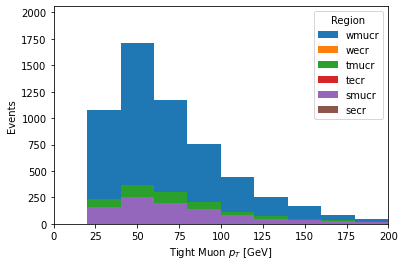

In [90]:
hist.plot1d(output['mu_pT'].integrate('dataset'), overlay='region',stack=True)

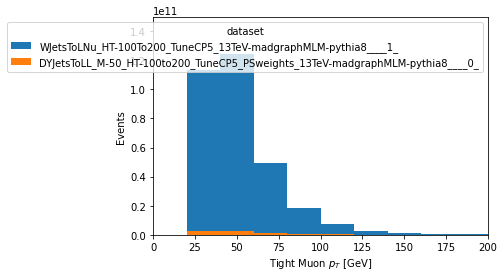

In [23]:
hist.plot1d(output['mu_pT'].integrate('region'), overlay='dataset',stack=True)

In [91]:
output['cutflow']

defaultdict_accumulator(int,
                        {'all events': 2861711,
                         'tight_e': 185336,
                         'tight_mu': 303537,
                         'loose_e': 362140,
                         'loose_mu': 397420,
                         'met>100': 96,
                         'met_triggers': 667257,
                         'ele_triggers': 260436,
                         'mu_triggers': 346017,
                         'Delta_Phi_Met_LJ': 1162952,
                         'DeltaR_LJ_Mu': 279240,
                         'exactly_1_medium_btag': 342652,
                         'DeltaR_LJ_Ele': 172900})

In [72]:
list(output['cutflow'].values())

[2861711,
 185336,
 303537,
 362140,
 397420,
 96,
 667257,
 260436,
 346017,
 1162952,
 279240,
 342652,
 172900,
 0,
 0]

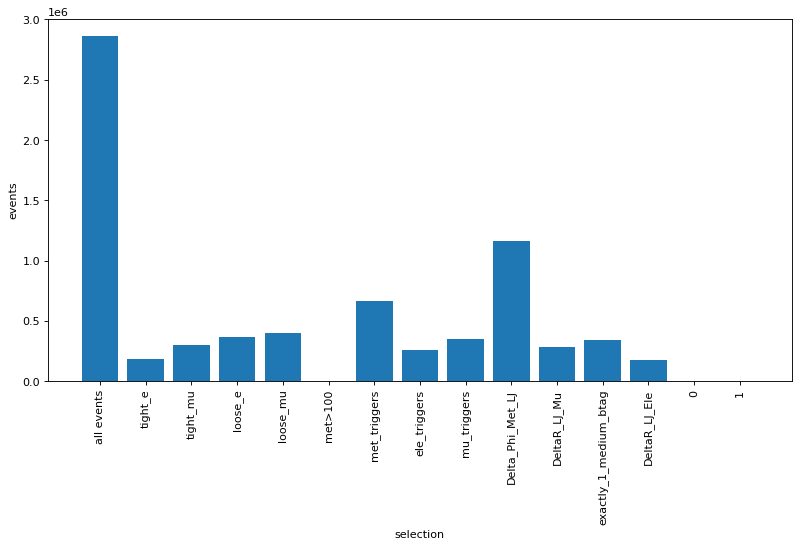

In [87]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')



plt.bar(range(len(output['cutflow'])), list(output['cutflow'].values()), align='center')
plt.xticks(range(len(output['cutflow'])), list(output['cutflow'].keys()), rotation=90)
# # for python 2.x:
# plt.bar(range(len(D)), D.values(), align='center')  # python 2.x
# plt.xticks(range(len(D)), D.keys())  # in python 2.x
plt.xlabel('selection')
plt.ylabel('events')
plt.show()


Text(0, 0.5, 'y')

<Figure size 960x480 with 0 Axes>

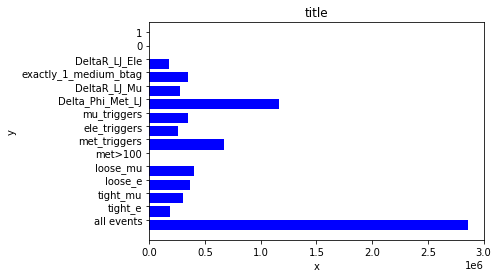

In [83]:
import os
import numpy as np
import matplotlib.pyplot as plt


x = list(output['cutflow'].keys())
y = list(output['cutflow'].values())

fig, ax = plt.subplots()    
width = 0.75 # the width of the bars 
ind = np.arange(len(y))  # the x locations for the groups
ax.barh(ind, y, width, color="blue")
ax.set_yticks(ind+width/2)
ax.set_yticklabels(x, minor=False)
plt.title('title')
plt.xlabel('x')
plt.ylabel('y') 

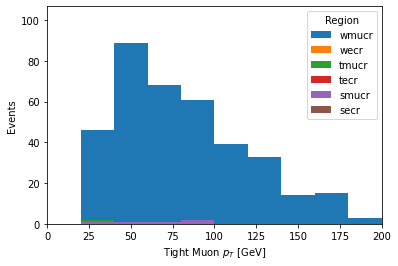

In [46]:
hist.plot1d(output['mu_pT'].integrate('dataset'), overlay='region',stack=True)

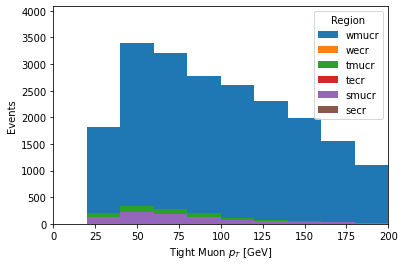

In [25]:
hist.plot1d(output['mu_pT'].integrate('dataset'), overlay='region',stack=True)

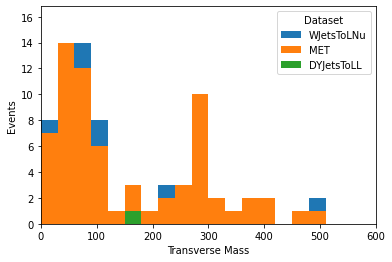

In [7]:
hist.plot1d(output['mT'].integrate('region'), overlay='dataset', stack=True) # loose

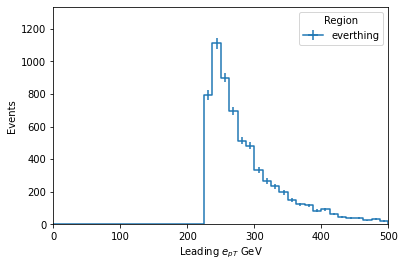

In [54]:
hist.plot1d(output['ele_pt'].integrate('dataset')) # loose

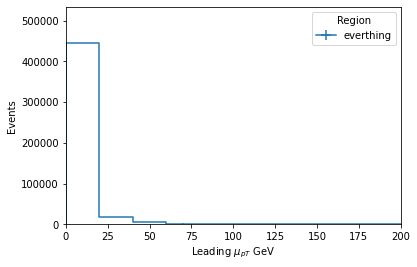

In [32]:
hist.plot1d(output['mu_pt'].integrate('dataset')) #after

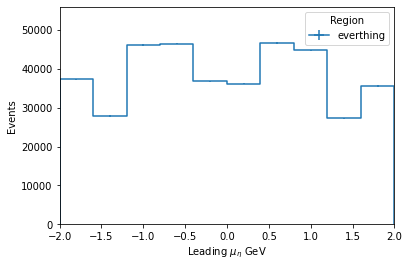

In [29]:
hist.plot1d(output['mu_eta'].integrate('dataset')) #before

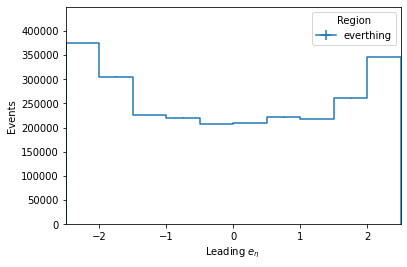

In [31]:
hist.plot1d(output['ele_eta'].integrate('dataset')) #after

In [112]:
with open('../metadata/'+'2018'+'.json') as fin:
    samplefiles = json.load(fin)
    xsec = {k: v['xs'] for k,v in samplefiles.items()}

In [114]:
xsec

{'MET____0_': -1,
 'MET____1_': -1,
 'MET____2_': -1,
 'MET____3_': -1,
 'MET____4_': -1,
 'MET____5_': -1,
 'MET____6_': -1,
 'MET____7_': -1,
 'MET____8_': -1,
 'MET____9_': -1,
 'MET____10_': -1,
 'MET____11_': -1,
 'MET____12_': -1,
 'MET____13_': -1,
 'MET____14_': -1,
 'MET____15_': -1,
 'MET____16_': -1,
 'MET____17_': -1,
 'MET____18_': -1,
 'MET____19_': -1,
 'MET____20_': -1,
 'MET____21_': -1,
 'MET____22_': -1,
 'MET____23_': -1,
 'MET____24_': -1,
 'MET____25_': -1,
 'MET____26_': -1,
 'MET____27_': -1,
 'MET____28_': -1,
 'MET____29_': -1,
 'MET____30_': -1,
 'MET____31_': -1,
 'MET____32_': -1,
 'MET____33_': -1,
 'MET____34_': -1,
 'MET____35_': -1,
 'MET____36_': -1,
 'MET____37_': -1,
 'MET____38_': -1,
 'MET____39_': -1,
 'MET____40_': -1,
 'MET____41_': -1,
 'MET____42_': -1,
 'MET____43_': -1,
 'MET____44_': -1,
 'MET____45_': -1,
 'MET____46_': -1,
 'MET____47_': -1,
 'MET____48_': -1,
 'MET____49_': -1,
 'MET____50_': -1,
 'MET____51_': -1,
 'MET____52_': -1,
 'M

In [33]:
a = 'MET____0_'

In [34]:
a.split('_')[0]

'MET'

In [ ]:
b = 'WJetsToLNu_Wpt-0To50_TuneCP5_13TeV-amcatnloFXFX-pythia8____27_'

In [52]:
if 'ZJetsToNuNu' in ['WJets', 'ZJets','DY','TT','ST','WW','WZ','ZZ','QCD','SingleElectron', 'MET']:
    print('hi')